Student: Luca Benfenati (s286582) | October, 2022

# Tesina MML - Drug consumption Dataset

## Introduction

The problem of evaluating an individual’s risk of drug consumption and misuse is highly important. An online survey methodology was employed to collect data including Big Five personality traits (NEO-FFI-R), impulsivity (BIS-11), sensation seeking (ImpSS), and demographic information. The data set contained information on the consumption of 18 central nervous system psychoactive drugs: alcohol, amphetamines, amyl nitrite, benzodiazepine, cannabis, chocolate, cocaine, caffeine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, mushrooms, nicotine and volatile substance abuse and one fictitious drug (Semeron) which was introduced to identify over-claimers. For each drug they have to select one of the answers: never used the drug, used it over a decade ago, or in the last decade, year, month, week, or day.

## 1) Dataset exploration

Database contains records for 1885 respondents. For each respondent 12 attributes are known: 
- Personality measurements which include NEO-FFI-R (neuroticism, extraversion, openness to experience, agreeableness, and conscientiousness), 
- BIS-11 (impulsivity), 
- ImpSS (sensation seeking), 
- level of education, 
- age, 
- gender, 
- country of residence,
- ethnicity. 

Database contains 18 classification problems, one for each drug. Each of independent label variables contains seven classes: "Never Used" (CL0), "Used over a Decade Ago" (CL1), "Used in Last Decade" (CL2), "Used in Last Year" (CL3), "Used in Last Month" (CL4), "Used in Last Week" (CL5), and "Used in Last Day" (CL6).

**IMPORT LIBRARIES**

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import mat73
import utils

# outlier removal libraries
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
# standardization libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# sampling libraries
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
# model libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
# utilities libraries
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
import warnings
import plotly.express as px
from sklearn.neighbors import NearestNeighbors

# settings
warnings.filterwarnings("ignore")
sns.set_theme()
sns.set_context("paper")

In [2]:
# define name of the columns
cols = ["ID", "Age", "Gender", "Education", "Country", "Ethnicity", "Nscore", "Escore", "Oscore", "Ascore", 
        "Cscore", "Impulsive", "SS", "Alchol", "Amphet", "Amyl", "Benzos", "Caff", "Cannabis", "Choc", "Coke", 
        "Crak", "Ecstasy", "Heroin", "Ketamine", "Legalh", "LSD", "Meth", "Mushrooms", "Nicotine", "Semer", "VSA"]

# read data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data', sep=",", header=None, names=cols)
data.head()

ID      Age   Gender  Education  Country  Ethnicity   Nscore   Escore  \
0   1  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545   
1   2 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886   
2   3  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523   
3   4 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615   
4   5  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340   

    Oscore   Ascore  ...  Ecstasy  Heroin  Ketamine Legalh  LSD Meth  \
0 -0.58331 -0.91699  ...      CL0     CL0       CL0    CL0  CL0  CL0   
1  1.43533  0.76096  ...      CL4     CL0       CL2    CL0  CL2  CL3   
2 -0.84732 -1.62090  ...      CL0     CL0       CL0    CL0  CL0  CL0   
3 -0.01928  0.59042  ...      CL0     CL0       CL2    CL0  CL0  CL0   
4 -0.45174 -0.30172  ...      CL1     CL0       CL0    CL1  CL0  CL0   

  Mushrooms Nicotine Semer  VSA  
0       CL0      CL2   CL0  CL0  
1       CL0      CL4   CL0  CL0  
2       CL1      CL0   CL0  CL0  
3       CL0      CL2   CL0  CL0  
4       CL2      CL2   CL0  CL0  

[5 rows x 32 columns]

### 1.1) Problem definition

First of all, we need to define the classification problem we want to solve.

We want to solve a **binary classification** problem, distinguishing between drug "User" and "Non-user". So basically: 
- The "User" class includes "Used in Last Decade" (CL2), "Used in Last Year" (CL3), "Used in Last Month" (CL4), "Used in Last Week" (CL5), and "Used in Last Day" (CL6).
- The "Non-User" class includes "Never Used" (CL0), "Used over a Decade Ago" (CL1).


In this way, a 7-classes classification problem has just been translated into a binary one. However, we still need to decide how the 18 different drugs must be treated.

In [3]:
label_dict = {
    "CL0": 0,
    "CL1": 0, 
    "CL2": 1,
    "CL3": 1,
    "CL4": 1,
    "CL5": 1,
    "CL6": 1
}

drugs = ['Alchol','Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crak', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']
new_data = data.copy()
for drug in drugs:
    new_data[drug] = data[drug].map(label_dict)

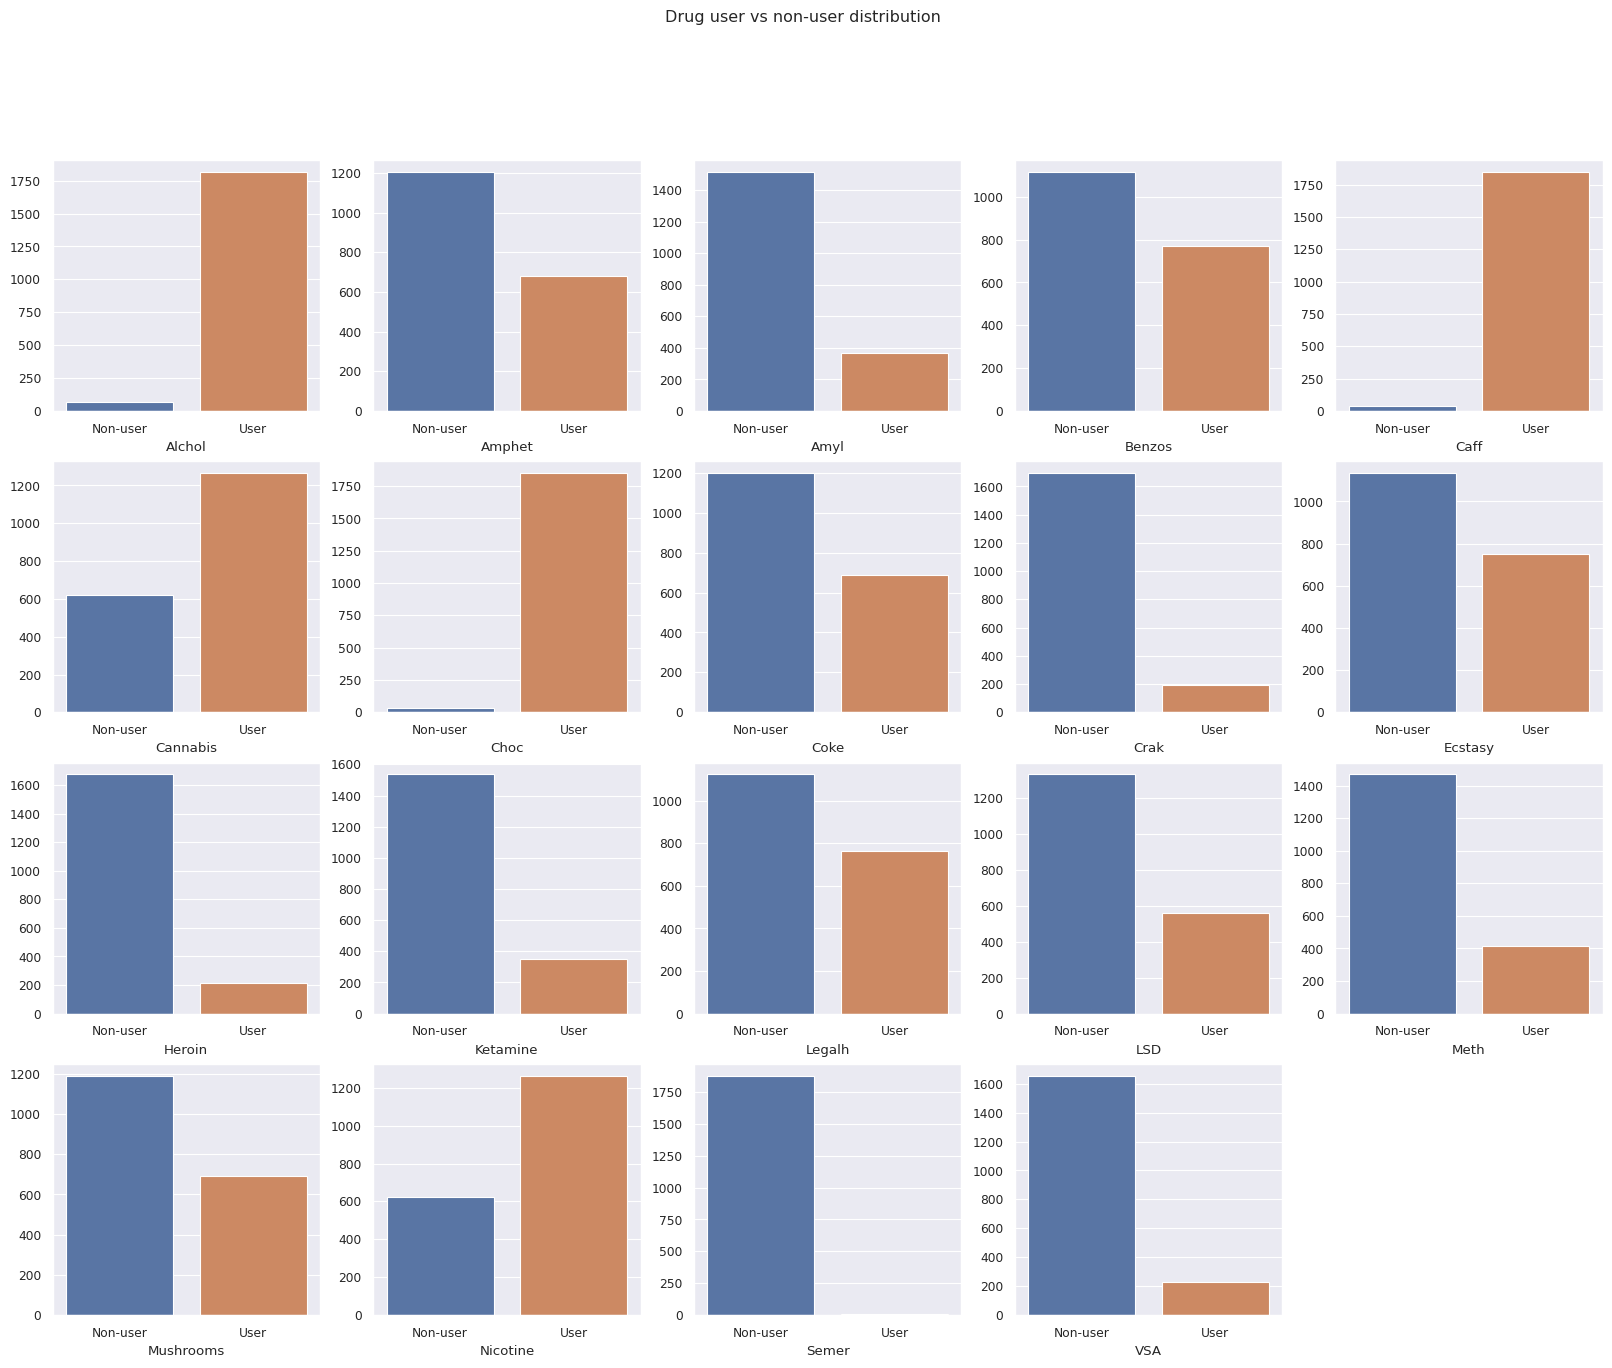

In [4]:
i = 1
fig, ax = plt.subplots(figsize=(20,15))
for drug in drugs: 
    plt.subplot(4, 5, i)
    ax = sns.countplot(x=drug, data=new_data)
    ax.set_xticklabels(["Non-user", "User"])
    ax.set_ylabel("")
    i = i+1
    
plt.suptitle('Drug user vs non-user distribution')
plt.show()

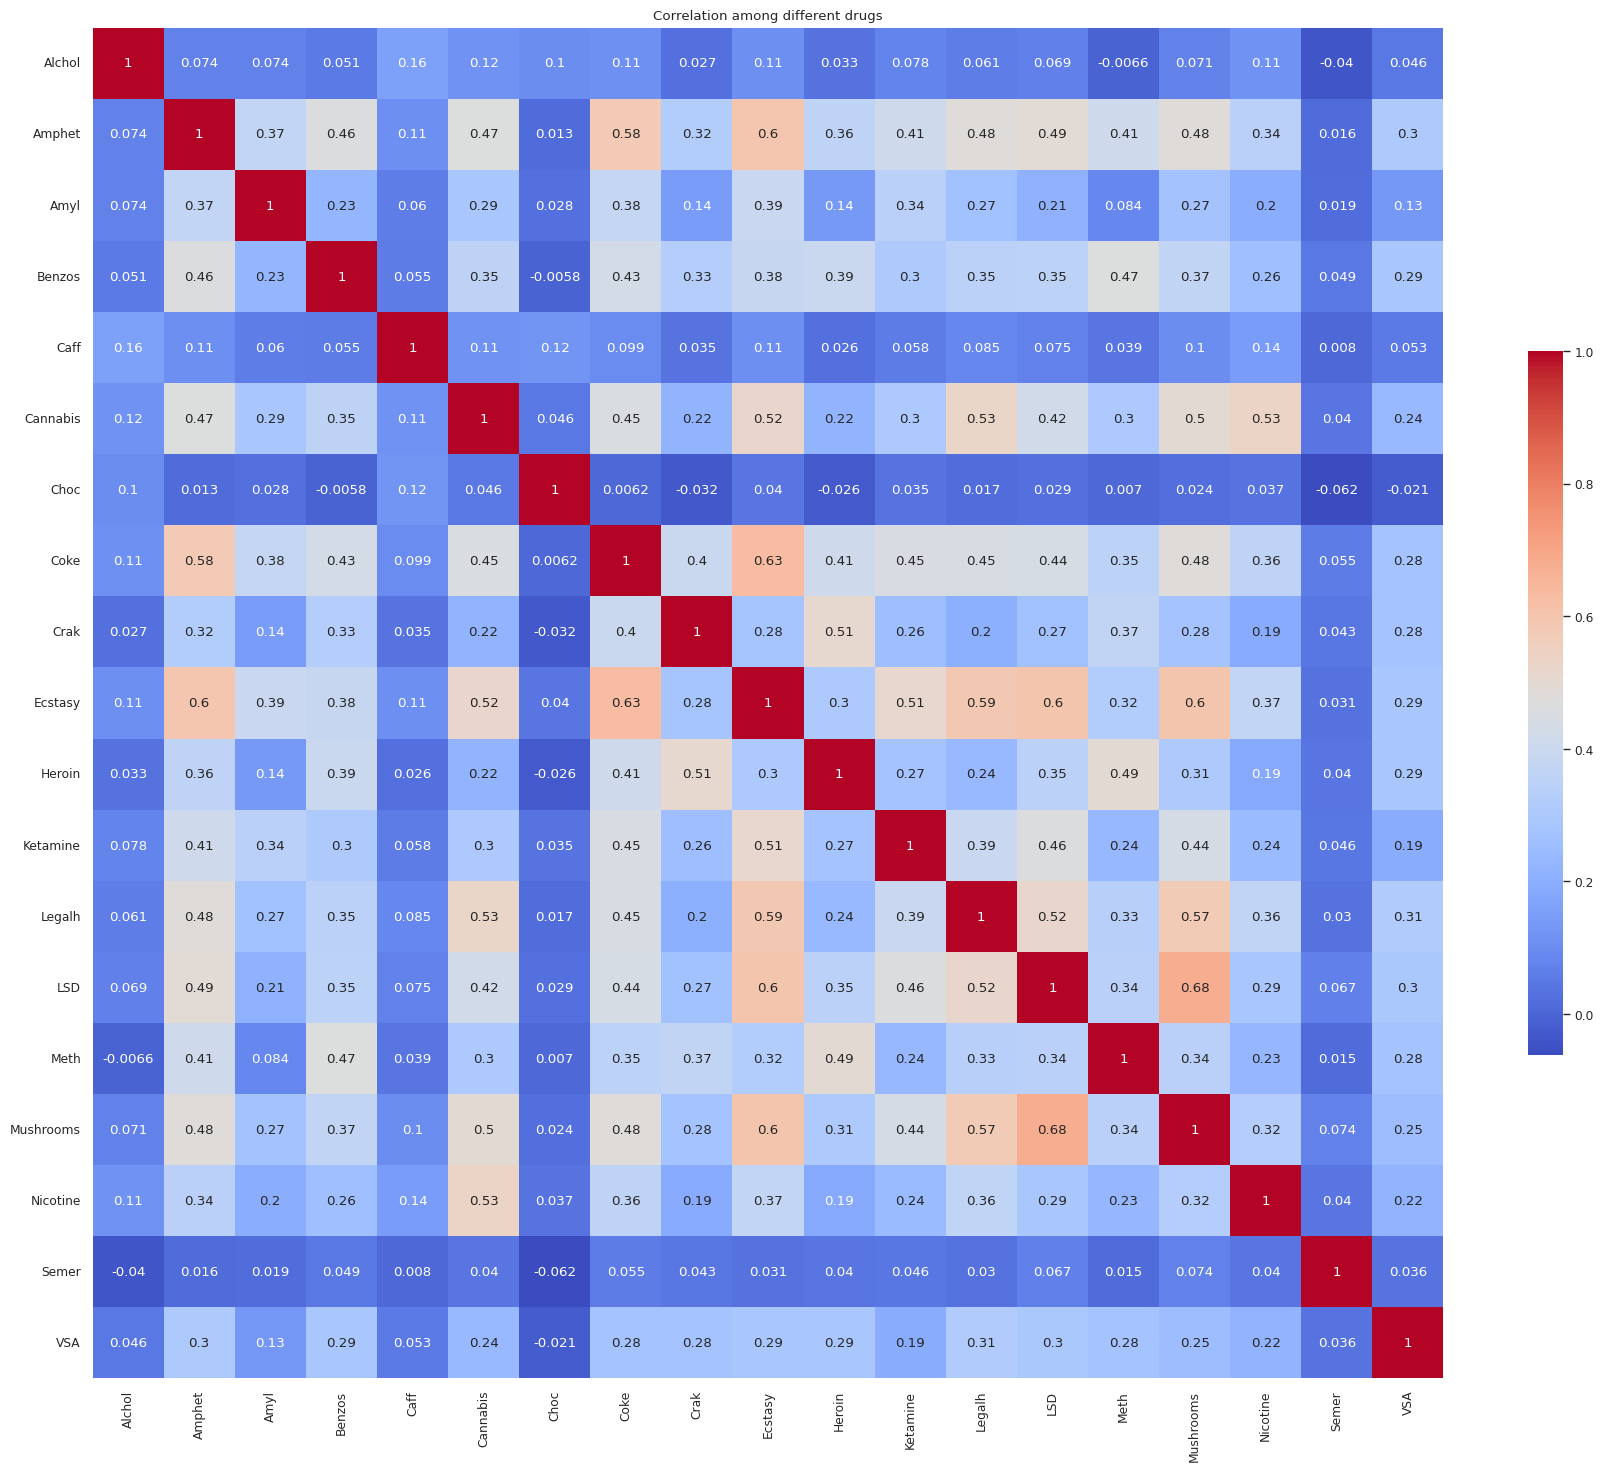

In [5]:
plt.figure(figsize=(18,15))
sns.heatmap(new_data[drugs].corr(method="kendall"), annot=True, square=True, cmap='coolwarm', cbar_kws={"shrink": 0.5})
plt.title("Correlation among different drugs")
plt.tight_layout()
#plt.savefig("image.jpeg")
plt.show()

In [6]:
new_data[drugs].corr(method="kendall").mean()

Alchol       0.118007
Amphet       0.384129
Amyl         0.243739
Benzos       0.321822
Caff         0.128604
Cannabis     0.350247
Choc         0.071498
Coke         0.387349
Crak         0.268740
Ecstasy      0.403103
Heroin       0.291675
Ketamine     0.317585
Legalh       0.357196
LSD          0.366452
Meth         0.295378
Mushrooms    0.376649
Nicotine     0.286374
Semer        0.079353
VSA          0.251192
dtype: float64

In [7]:
print("Highest mean correlation drug --> {} ({})".format((new_data[drugs].corr(method="kendall").mean()).idxmax(), (new_data[drugs].corr(method="kendall").mean()).max()))

Highest mean correlation drug --> Ecstasy (0.403102541403659)


Ecstasy is the drug with the highest mean correlation with the other drugs. For this reason, in this first analysis Ecstasy will be the drug considered. Our objective is to predict wheter a given subject is a "Ecstasy User" or not.

Let's see how user are redistributed within the Ecstasy case, considering both:
1. the 7 classes and
2. the 2 binary classes (User vs Non-User)

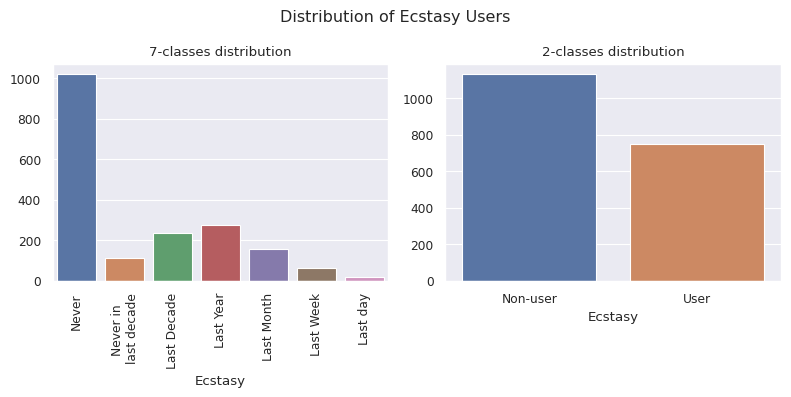

In [8]:
ecstasy_data = pd.concat([data.iloc[:, 1:13], data["Ecstasy"]], axis=1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("7-classes distribution")
ax = sns.countplot(x="Ecstasy", data=ecstasy_data, order = ["CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"])
ax.set_xticklabels(["Never", "Never in \nlast decade", "Last Decade", "Last Year", "Last Month", "Last Week", "Last day"], rotation=90)
ax.set_ylabel("")

plt.subplot(1, 2, 2)
plt.title("2-classes distribution")
ax = sns.countplot(x="Ecstasy", data=new_data)
ax.set_xticklabels(["Non-user", "User"])
ax.set_ylabel("")

plt.suptitle("Distribution of Ecstasy Users")
plt.tight_layout()
plt.show()

In [9]:
# Select drug of interest
selected_data = pd.concat([new_data.iloc[:, 1:13], new_data["Ecstasy"]], axis=1)
selected_data

Age   Gender  Education  Country  Ethnicity   Nscore   Escore  \
0     0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545   
1    -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886   
2     0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523   
3    -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615   
4     0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340   
...       ...      ...        ...      ...        ...      ...      ...   
1880 -0.95197  0.48246   -0.61113 -0.57009   -0.31685 -1.19430  1.74091   
1881 -0.95197 -0.48246   -0.61113 -0.57009   -0.31685 -0.24649  1.74091   
1882 -0.07854  0.48246    0.45468 -0.57009   -0.31685  1.13281 -1.37639   
1883 -0.95197  0.48246   -0.61113 -0.57009   -0.31685  0.91093 -1.92173   
1884 -0.95197 -0.48246   -0.61113  0.21128   -0.31685 -0.46725  2.12700   

       Oscore   Ascore   Cscore  Impulsive       SS  Ecstasy  
0    -0.58331 -0.91699 -0.00665   -0.21712 -1.18084        0  
1     1.43533  0.76096 -0.14277   -0.71126 -0.21575        1  
2    -0.84732 -1.62090 -1.01450   -1.37983  0.40148        0  
3    -0.01928  0.59042  0.58489   -1.37983 -1.18084        0  
4    -0.45174 -0.30172  1.30612   -0.21712 -0.21575        0  
...       ...      ...      ...        ...      ...      ...  
1880  1.88511  0.76096 -1.13788    0.88113  1.92173        0  
1881  0.58331  0.76096 -1.51840    0.88113  0.76540        1  
1882 -1.27553 -1.77200 -1.38502    0.52975 -0.52593        1  
1883  0.29338 -1.62090 -2.57309    1.29221  1.22470        1  
1884  1.65653  1.11406  0.41594    0.88113  1.22470        1  

[1885 rows x 13 columns]

### 1.2) Feature distribution

In [10]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        1885 non-null   float64
 1   Gender     1885 non-null   float64
 2   Education  1885 non-null   float64
 3   Country    1885 non-null   float64
 4   Ethnicity  1885 non-null   float64
 5   Nscore     1885 non-null   float64
 6   Escore     1885 non-null   float64
 7   Oscore     1885 non-null   float64
 8   Ascore     1885 non-null   float64
 9   Cscore     1885 non-null   float64
 10  Impulsive  1885 non-null   float64
 11  SS         1885 non-null   float64
 12  Ecstasy    1885 non-null   int64  
dtypes: float64(12), int64(1)
memory usage: 191.6 KB


In [11]:
age_mapping =  {
    "-0.95197": "18-24",
    "-0.07854": "25-34",
    "0.49788": "35-44",
    "1.09449": "45-54",
    "1.82213": "55-64",
    "2.59171": "65+"}

gender_mapping = {
    "0.48246": "Female",
    "-0.48246": "Male"
    }

education_mapping = {
    "-2.43591": "Left school before 16 years",
    "-1.7379": "Left school at 16 years",
    "-1.43719": "Left school at 17 years",
    "-1.22751": "Left school at 18 years",
    "-0.61113": "Some college or university, \n no certificate or degree",
    "-0.05921": "Certificate/diploma",
    "0.45468": "University degree",
    "1.16365": "Masters degree", 
    "1.98437": "Doctorate"
    }

country_mapping = {
    "-0.09765": "Australia",
    "0.24923": "Canada",
    "-0.46841": "New Zealand",
    "-0.28519": "Other",
    "0.21128": "Republic of Ireland",
    "0.96082": "UK",
    "-0.57009": "USA"
    }

ethnicity_mapping = {
    "-0.50212": "Asian",
    "-1.10702": "Black",
    "1.90725": "Mixed-Black/Asian",
    "0.126": "Mixed-White/Asian",
    "-0.22166": "Mixed-White/Black",
    "0.1144": "Other",
    "-0.31685": "White"
    }

mappings = [age_mapping, gender_mapping, education_mapping, country_mapping, ethnicity_mapping]

mapped_data = selected_data.copy()
for feature, mapping in zip(["Age", "Gender", "Education", "Country", "Ethnicity"], mappings): 
    mapped_data[feature] = mapped_data[feature].apply(lambda x: mapping[str(x)])
    
mapped_data.head()

Age  Gender            Education Country          Ethnicity   Nscore  \
0  35-44  Female  Certificate/diploma      UK  Mixed-White/Asian  0.31287   
1  25-34    Male            Doctorate      UK              White -0.67825   
2  35-44    Male  Certificate/diploma      UK              White -0.46725   
3  18-24  Female       Masters degree      UK              White -0.14882   
4  35-44  Female            Doctorate      UK              White  0.73545   

    Escore   Oscore   Ascore   Cscore  Impulsive       SS  Ecstasy  
0 -0.57545 -0.58331 -0.91699 -0.00665   -0.21712 -1.18084        0  
1  1.93886  1.43533  0.76096 -0.14277   -0.71126 -0.21575        1  
2  0.80523 -0.84732 -1.62090 -1.01450   -1.37983  0.40148        0  
3 -0.80615 -0.01928  0.59042  0.58489   -1.37983 -1.18084        0  
4 -1.63340 -0.45174 -0.30172  1.30612   -0.21712 -0.21575        0

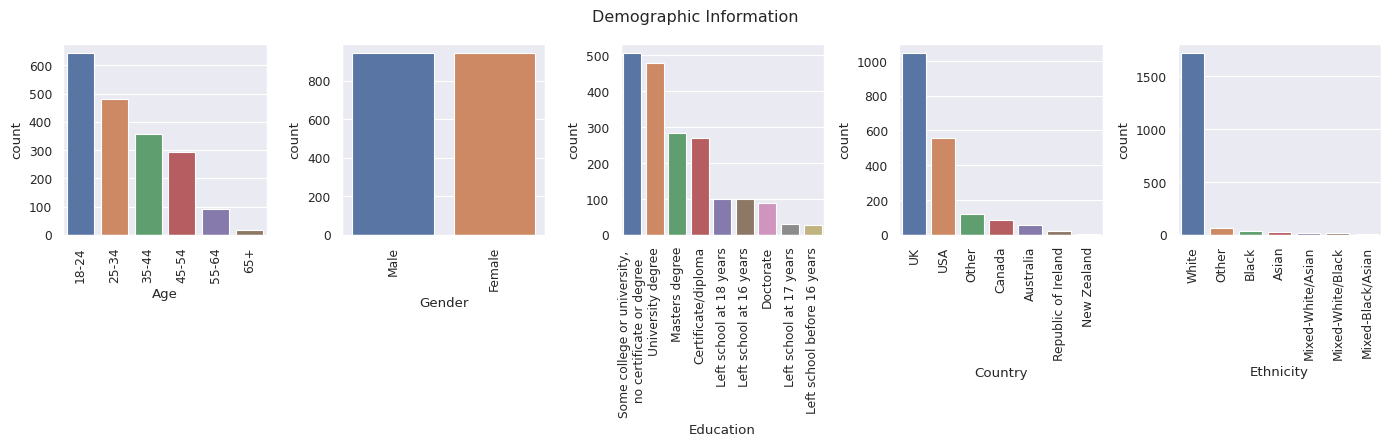

In [12]:
fig, ax = plt.subplots(figsize=(14,4.5))

plt.subplot(1, 5, 1)
ax = sns.countplot(x="Age", data=mapped_data, order = mapped_data['Age'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

plt.subplot(1, 5, 2)
ax = sns.countplot(x="Gender", data=mapped_data, order = mapped_data['Gender'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

plt.subplot(1, 5, 3)
ax = sns.countplot(x="Education", data=mapped_data, order = mapped_data['Education'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

plt.subplot(1, 5, 4)
ax = sns.countplot(x="Country", data=mapped_data, order = mapped_data['Country'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

plt.subplot(1, 5, 5)
ax = sns.countplot(x="Ethnicity", data=mapped_data, order = mapped_data['Ethnicity'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

fig.suptitle('Demographic Information')
plt.tight_layout()
plt.show()

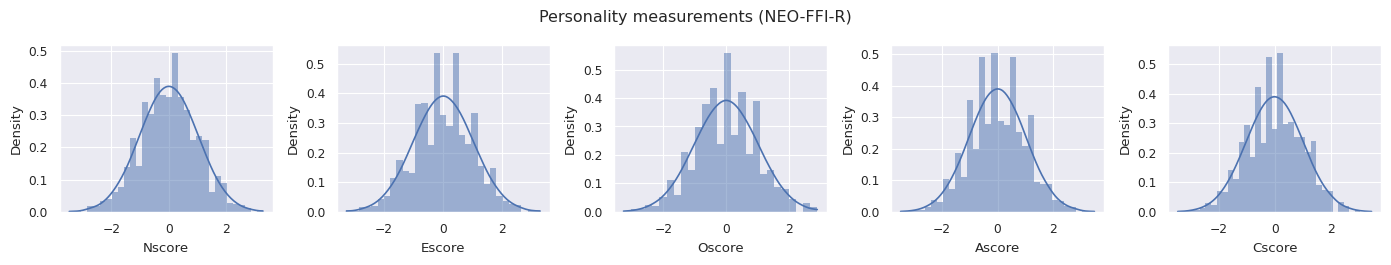

In [13]:
fig, ax = plt.subplots(figsize=(14,4.5))
plt.subplot(2,5,1)
sns.histplot(selected_data['Nscore'], kde=True, stat="density", linewidth=0)

plt.subplot(2,5,2)
sns.histplot(selected_data['Escore'], kde=True, stat="density", linewidth=0)

plt.subplot(2,5,3)
sns.histplot(selected_data['Oscore'], kde=True, stat="density", linewidth=0)

plt.subplot(2,5,4)
sns.histplot(selected_data['Ascore'], kde=True, stat="density", linewidth=0)

plt.subplot(2,5,5)
sns.histplot(selected_data['Cscore'], kde=True, stat="density", linewidth=0)

fig.suptitle('Personality measurements (NEO-FFI-R)')
plt.tight_layout()
plt.show()

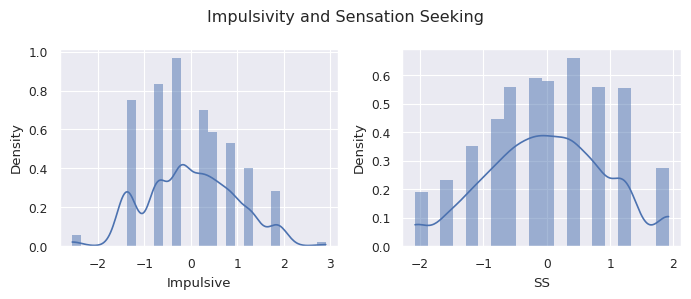

In [14]:
fig, ax = plt.subplots(figsize=(7, 3))
plt.subplot(1,2,1)
sns.histplot(selected_data['Impulsive'], kde=True, stat="density", linewidth=0)

plt.subplot(1,2,2)
sns.histplot(selected_data['SS'], kde=True, stat="density", linewidth=0)

fig.suptitle('Impulsivity and Sensation Seeking')
plt.tight_layout()
plt.show()

### 1.3) Correlation between features

<Figure size 1000x500 with 0 Axes>

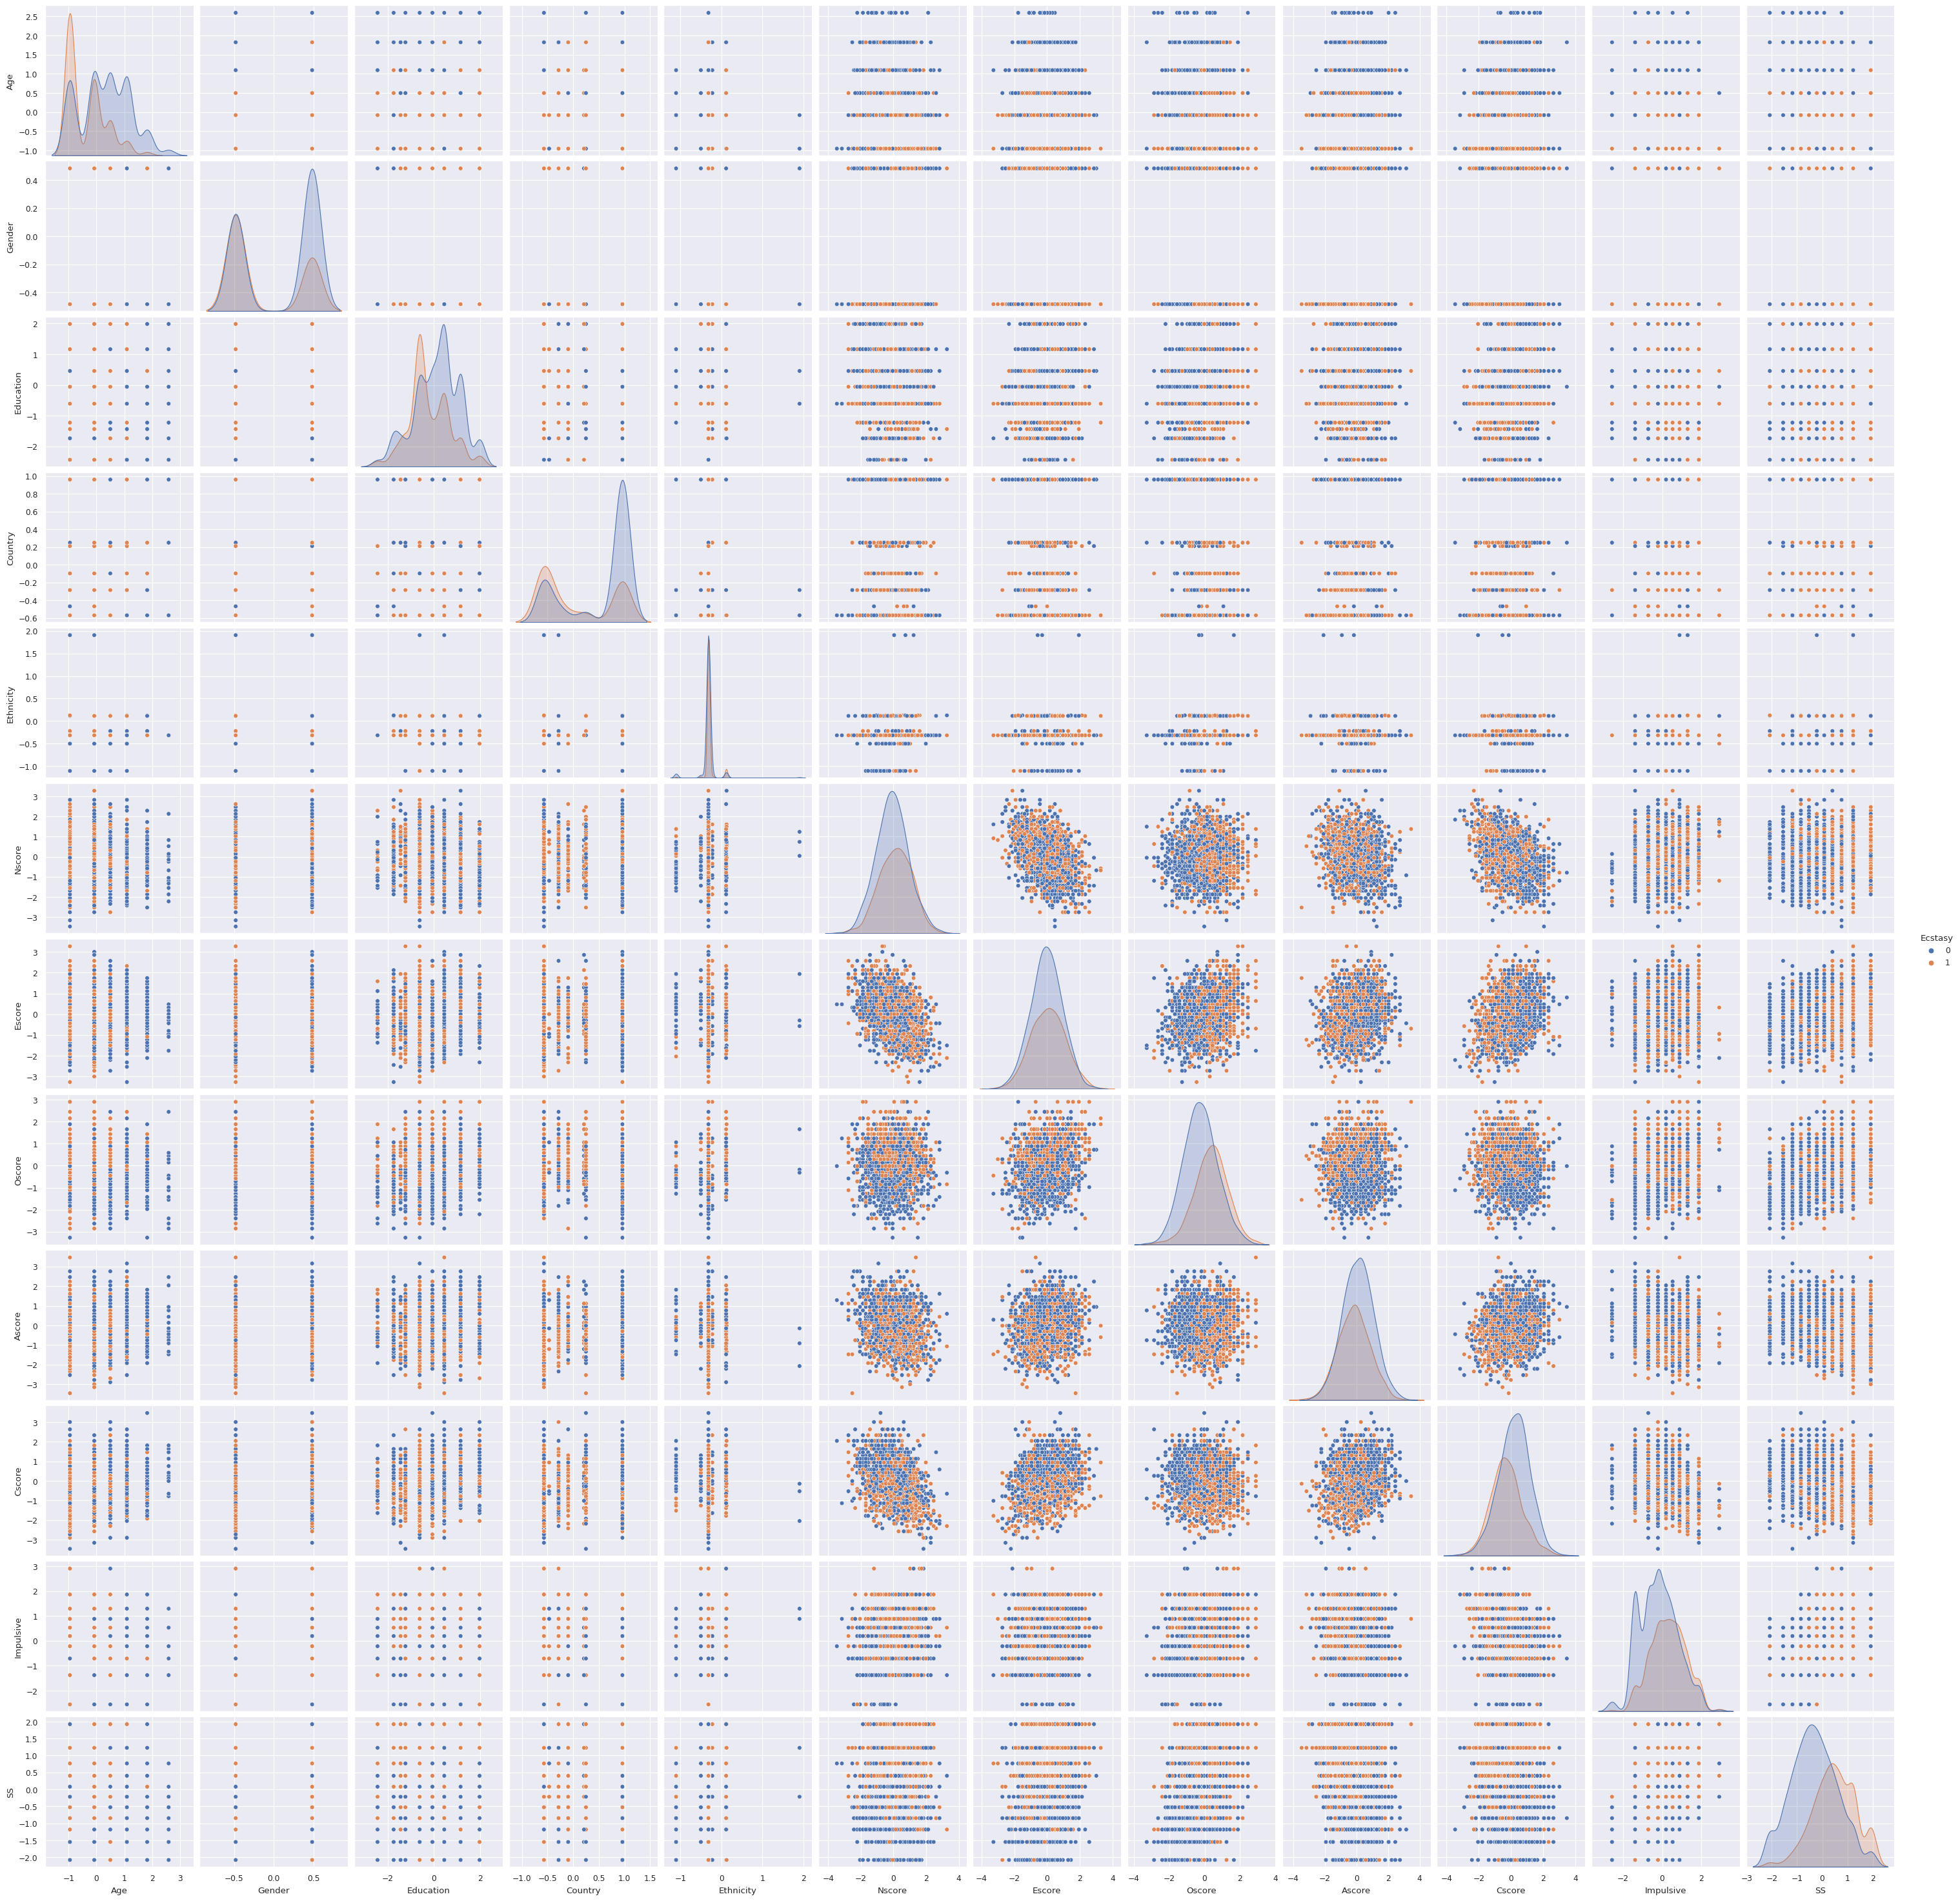

In [15]:
plt.figure(figsize=(10,5))
sns.pairplot(selected_data, hue="Ecstasy")
#plt.savefig("pair_plot.jpeg")
plt.show()

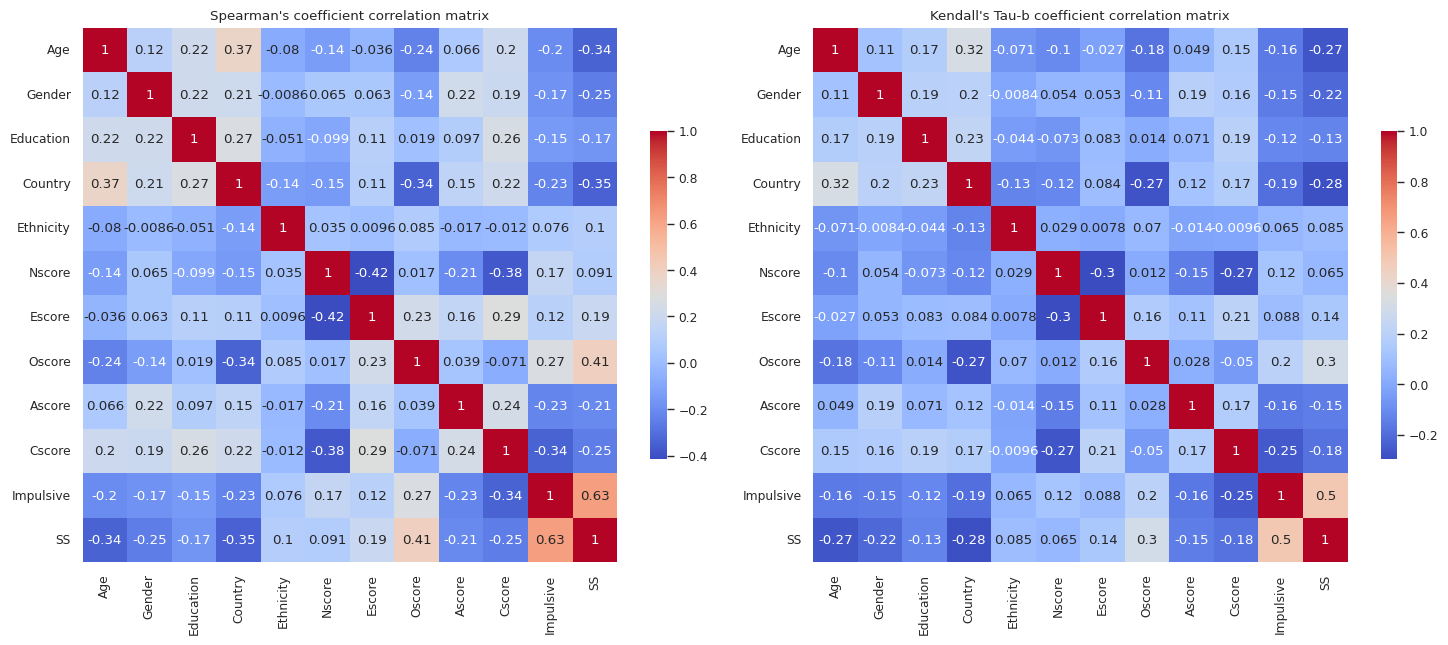

In [16]:
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
sns.heatmap(selected_data.iloc[:, 0:12].corr(method="spearman"), annot=True, square=True, cmap='coolwarm', cbar_kws={"shrink": 0.5})
plt.title("Spearman's coefficient correlation matrix")

plt.subplot(1, 2, 2)
sns.heatmap(selected_data.iloc[:, 0:12].corr(method="kendall"), annot=True, square=True, cmap='coolwarm', cbar_kws={"shrink": 0.5})
plt.title("Kendall's Tau-b coefficient correlation matrix")

plt.tight_layout()
plt.show()

### 1.4) Boxplots

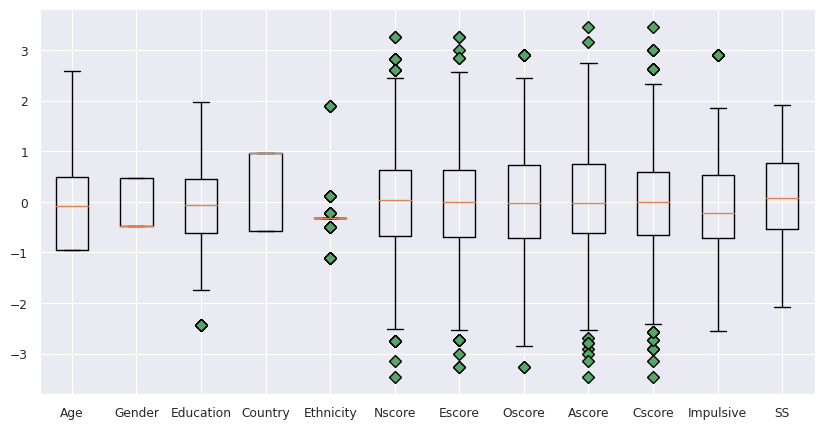

In [17]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('')
ax.boxplot(selected_data.iloc[:, 0:12], flierprops=green_diamond)
ax.set_xticklabels(selected_data.columns[0:12])
plt.show()

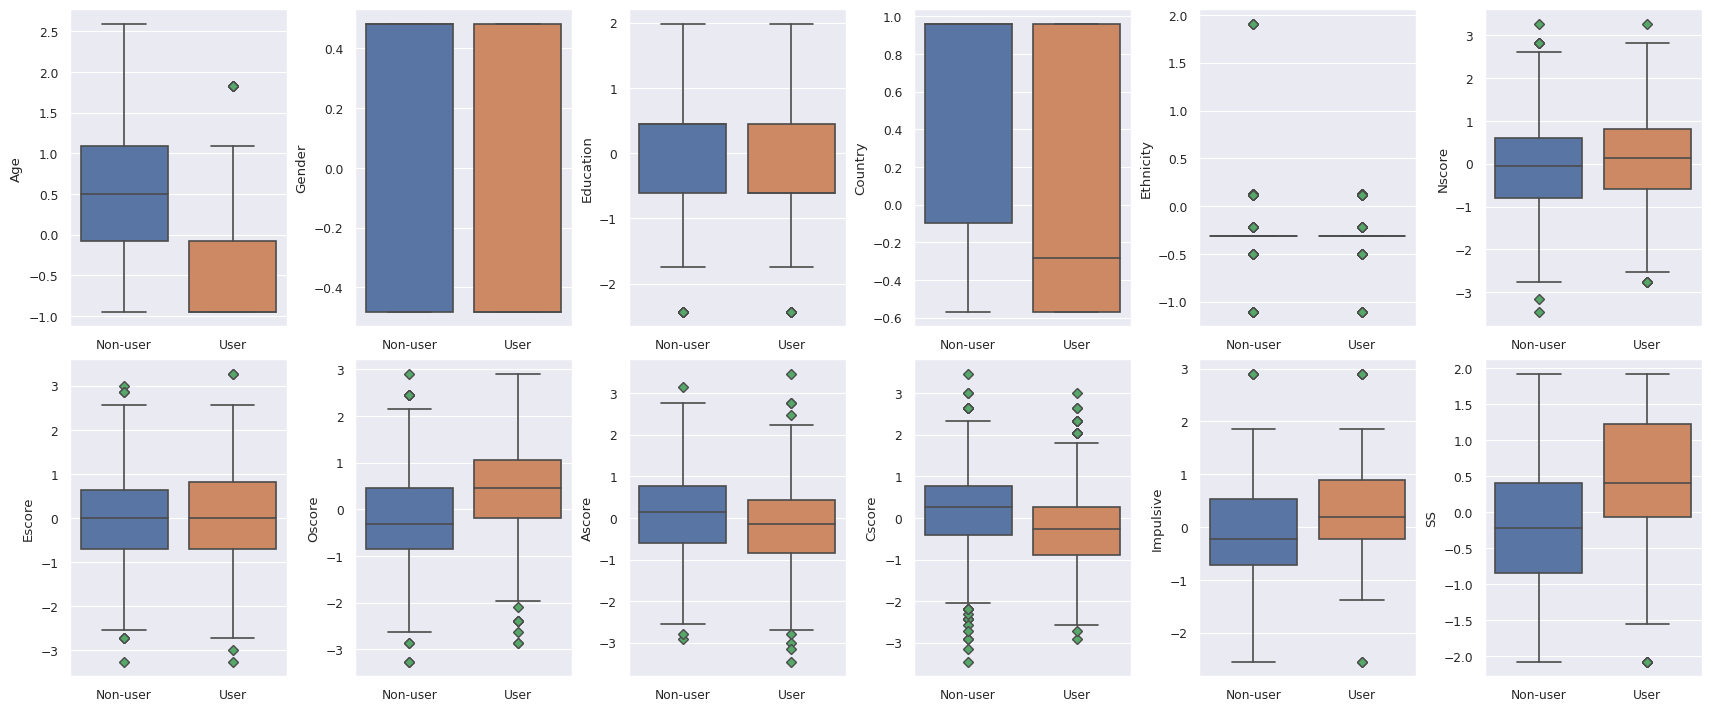

In [18]:
i = 1
fig, ax = plt.subplots(figsize=(17, 7), constrained_layout=True)
for feat in selected_data.columns[:12]: 
    plt.subplot(2, 6, i)
    ax = sns.boxplot(x="Ecstasy", y=feat, #palette=["green", "orange"],
                     data=selected_data, flierprops=green_diamond)
    ax.set_xticklabels(["Non-user", "User"])
    plt.xlabel('')
    i = i+1
    
plt.show()

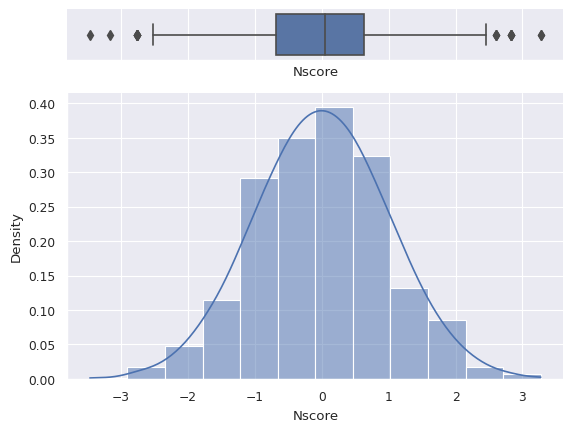

In [19]:
x = selected_data["Nscore"]
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=x, ax=ax_box)
sns.histplot(x=x, bins=12, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

## 2) Data preparation

In [20]:
# Define target variable
y=selected_data['Ecstasy'].tolist()
y=np.array(y)

X = selected_data.drop(columns=["Ecstasy"])
x_columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, stratify=y, random_state=42)
X_train_new_m=X_train.to_numpy()
y_train.shape

(1508,)

### 2.1) Feature scaling

#### 2.1.1) Standard Scaler

In [21]:
autoscaler = StandardScaler()

features = autoscaler.fit_transform(X_train)
test=autoscaler.transform(X_train.iloc[:, 0:12])

#### 2.1.2) Min Max Scaler

In [22]:
autoscaler = MinMaxScaler()

features = autoscaler.fit_transform(X_train)
test=autoscaler.transform(X_train.iloc[:, 0:12])

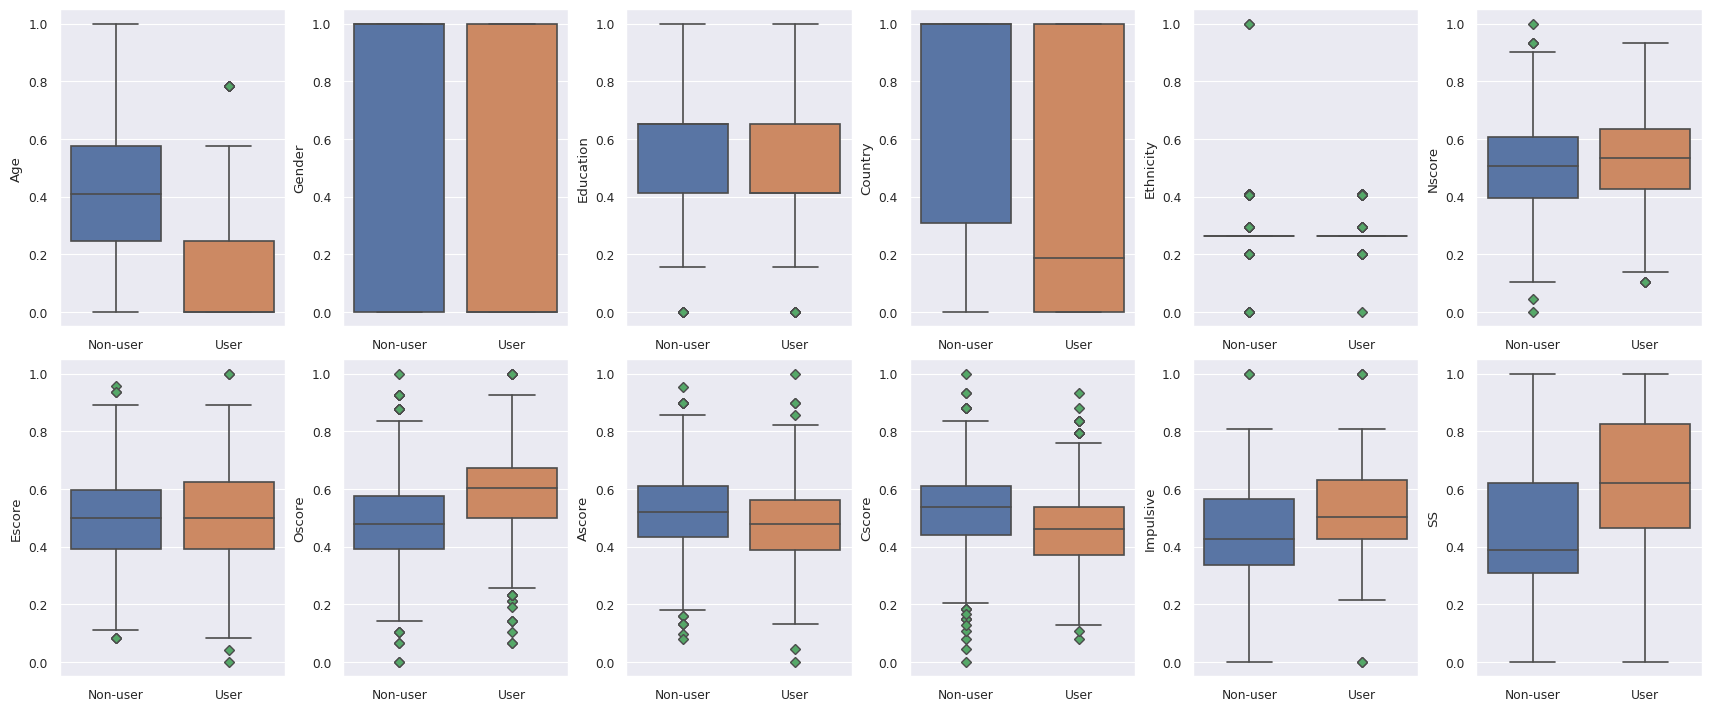

In [23]:
scaled_dataframe = pd.DataFrame(test, columns=list(X_train.columns))
scaled_dataframe["Ecstasy"] = y_train
green_diamond = dict(markerfacecolor='g', marker='D')

i = 1
fig, ax = plt.subplots(figsize=(17, 7), constrained_layout=True)
for feat in scaled_dataframe.columns[:12]: 
    plt.subplot(2, 6, i)
    ax = sns.boxplot(x="Ecstasy", y=feat, #palette=["green", "orange"],
                     data=scaled_dataframe, flierprops=green_diamond)
    ax.set_xticklabels(["Non-user", "User"])
    plt.xlabel('')
    i = i+1
    
plt.show()

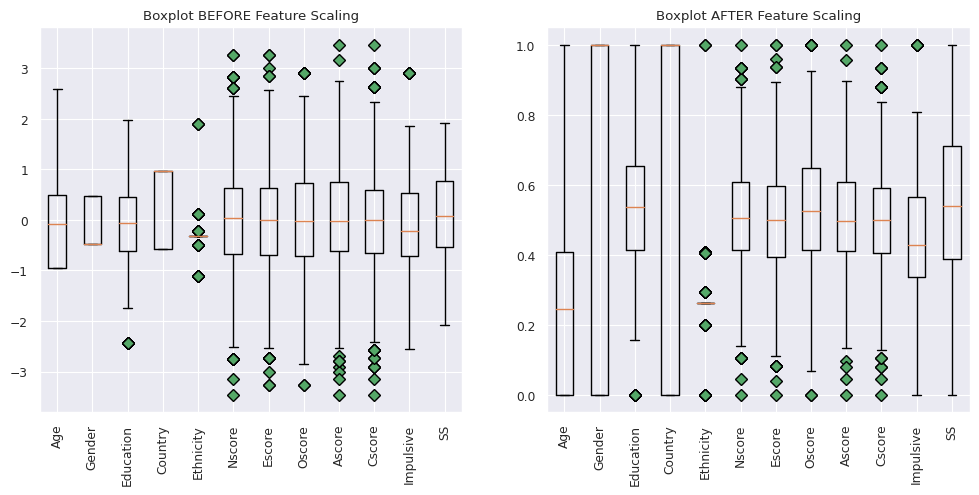

In [24]:
scaled_dataframe = pd.DataFrame(test, columns=list(X_train.columns))
scaled_dataframe["Ecstasy"] = y_train

green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Boxplot BEFORE Feature Scaling')
plt.boxplot(selected_data.iloc[:, 0:12], flierprops=green_diamond)
plt.xticks(range(1, 13), selected_data.columns[0:12], rotation=90)

plt.subplot(1, 2, 2)
plt.title('Boxplot AFTER Feature Scaling')
plt.boxplot(scaled_dataframe.iloc[:, 0:12], flierprops=green_diamond)
plt.xticks(range(1, 13), selected_data.columns[0:12], rotation=90)
plt.show()

### 2.2) Outlier management and removal

#### 2.2.1) Isolation forest

In [25]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

# select all rows that are not outliers
mask = yhat != -1
X_train_iso, y_train_iso = X_train_new_m[mask, :], y_train[mask]

len(X_train_iso)

1357

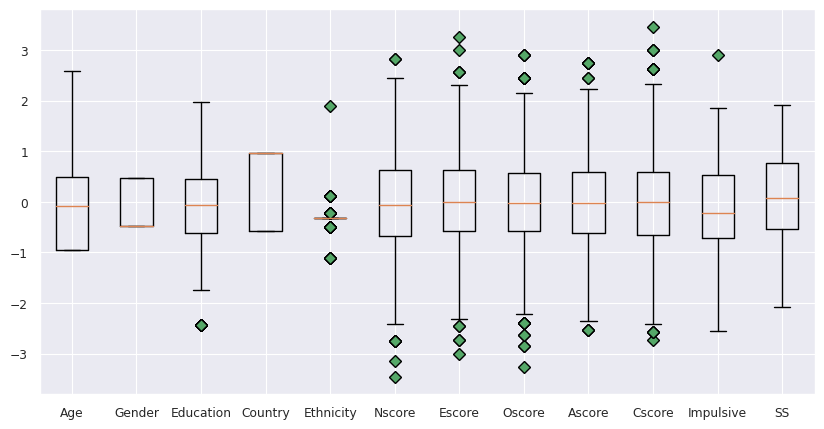

In [26]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('')
ax.boxplot(X_train_iso[:, 0:12], flierprops=green_diamond)
ax.set_xticklabels(selected_data.columns[0:12])
plt.show()

#### 2.2.2) LOF - Local Outlier Factor

In [27]:
# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)

# select all rows that are not outliers
mask = yhat != -1
X_train_lof, y_train_lof = X_train_new_m[mask, :], y_train[mask]
len(X_train_lof)

1500

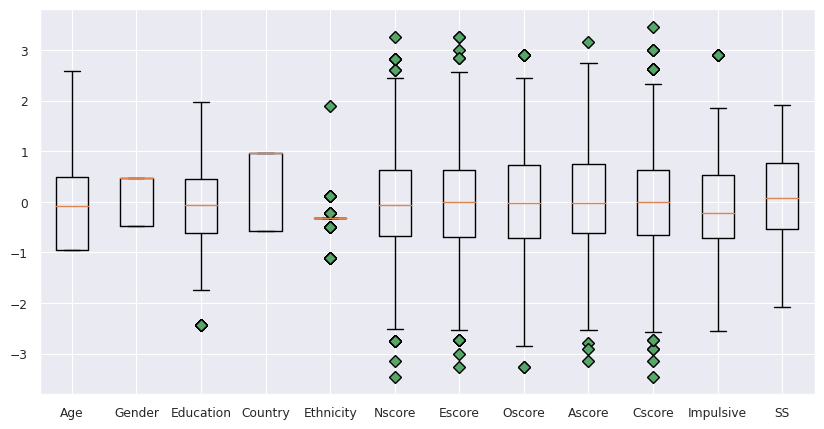

In [28]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('')
ax.boxplot(X_train_lof[:, 0:12], flierprops=green_diamond)
ax.set_xticklabels(x_columns)
plt.show()

#### 2.2.3) DBSCAN

In [29]:
clusters = np.zeros(X_train.shape[0])
for feature in X_train.columns:
    clust=utils.remove_outliers_DBSCAN((X_train[feature]),0.15,12)
    clust[clust != -1] = 0
    clusters += clust
    

mask = clusters >= 0
X_train_dbscan, y_train_dbscan = X_train_new_m[mask, :], y_train[mask]
X_train_dbscan.shape

(1351, 12)

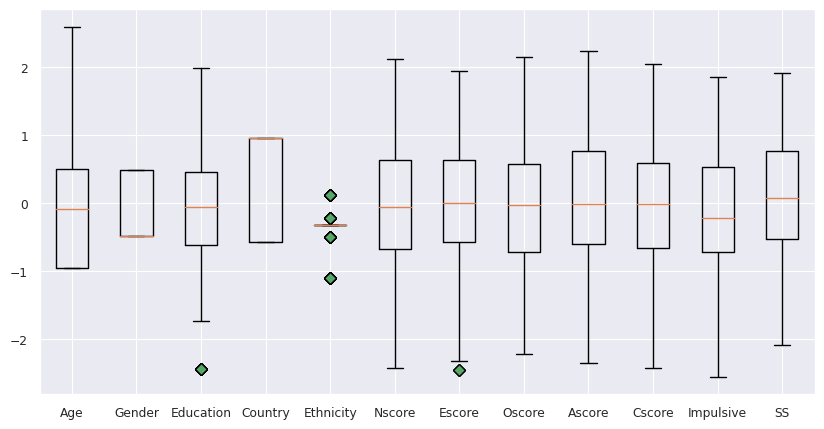

In [30]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('')
ax.boxplot(X_train_dbscan[:, 0:12], flierprops=green_diamond)
ax.set_xticklabels(selected_data.columns[0:12])
plt.show()

##### Find eps and minPoints for DBSCAN
- As a rule of thumb, the number of neighbors is at least greater of equal to the number of features. A common value is to consider two times the number of features. In our case we have n_neighbors = 24
- to establish the value of eps, we need to look at the K-distance graph and its elbow

In [31]:
n_neighbors = 24

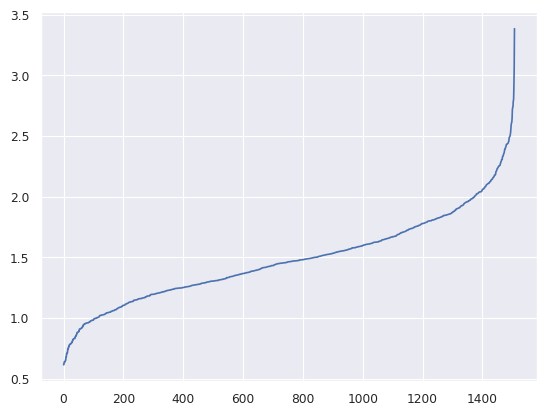

In [32]:
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### 2.2.4) Comparison between methods

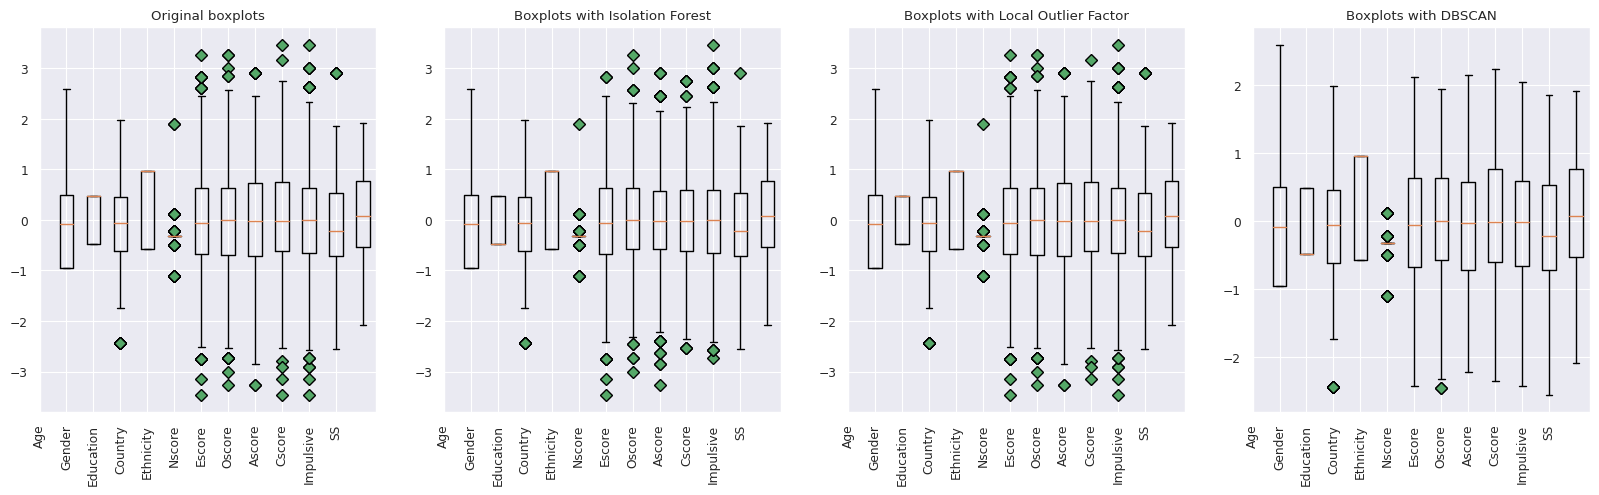

In [33]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots(figsize=(20, 5))


plt.subplot(1, 4, 1)
plt.title('Original boxplots')
plt.boxplot(X_train.iloc[:, 0:12], flierprops=green_diamond)
plt.xticks(ticks = range(len(selected_data.columns[0:12])), labels=list(selected_data.columns[0:12]), rotation=90)

plt.subplot(1, 4, 2)
plt.title('Boxplots with Isolation Forest')
plt.boxplot(X_train_iso[:, 0:12], flierprops=green_diamond)
plt.xticks(ticks = range(len(selected_data.columns[0:12])), labels=list(selected_data.columns[0:12]), rotation=90)

plt.subplot(1, 4, 3)
plt.title('Boxplots with Local Outlier Factor')
plt.boxplot(X_train_lof[:, 0:12], flierprops=green_diamond)
plt.xticks(ticks = range(len(selected_data.columns[0:12])), labels=list(selected_data.columns[0:12]), rotation=90)

plt.subplot(1, 4, 4)
plt.title('Boxplots with DBSCAN')
plt.boxplot(X_train_dbscan[:, 0:12], flierprops=green_diamond)
plt.xticks(ticks = range(len(selected_data.columns[0:12])), labels=list(selected_data.columns[0:12]), rotation=90)


plt.show()

### 2.3) Dimensionality Reduction: PCA

In [34]:
n_components = 7

scaler = StandardScaler()
pca = PCA(n_components=n_components)

X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)


test=scaler.transform(X_test.iloc[:, 0:12])
X_test_pca=pca.transform(test)

print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.2f}")

Total variance explained: 0.80


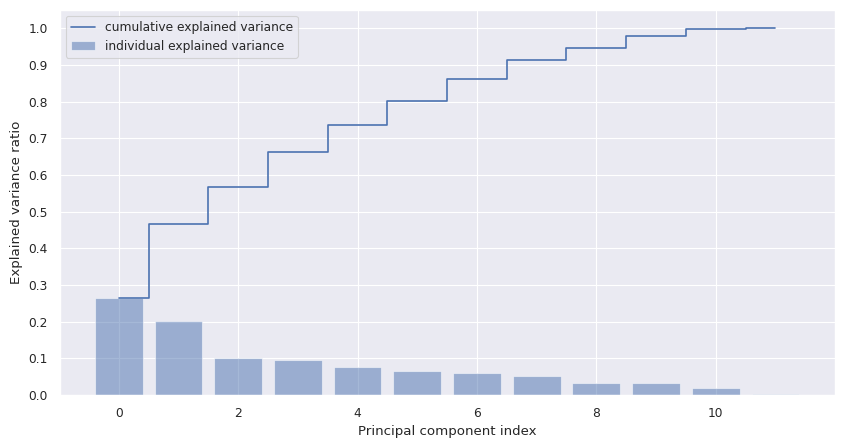

In [35]:
cov_mat = np.cov(X_train.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
#print(var_exp)
# plot explained variances


plt.figure(figsize=(10, 5))
plt.bar(range(0,12), var_exp, alpha=0.5,align='center', label='individual explained variance')
plt.step(range(0,12), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.yticks(ticks=[x/10 for x in list(range(0, 11, 1))])
#plt.xticks(ticks=[x/10 for x in list(range(0, 13, 1))])
plt.xlabel('Principal component index')

plt.legend(loc='best')
plt.show()

#### Visualize principal components

In [36]:
features = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore',
            'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']

pca = PCA(n_components=n_components)
components = pca.fit_transform(X_train[features])

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

In [37]:
fig = px.scatter_matrix(
    components,
    color=y_train,
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%'
)
fig.update_traces(diagonal_visible=True)
fig.show(renderer='browser')

## 3) Sampling methods

In [38]:
# Define target variable
y=selected_data['Ecstasy'].tolist()
y=np.array(y)

X = selected_data.drop(columns=["Ecstasy"])

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, stratify=y, random_state=42)
X_train_numpy=X_train.to_numpy()
y_train.shape

(1508,)

### 3.1) Downsampling

#### 3.1.1) Cluster Centroids

In [39]:
X_train_downsample_cc, y_train_downsample_cc = ClusterCentroids(random_state=0).fit_resample(X_train, y_train)

X_train_downsample_cc.shape

(1202, 12)

#### 3.1.2) Random Under Sampler

Note: RandomUnderSampler allows to bootstrap the data by setting replacement to True. The resampling with multiple classes is performed by considering independently each targeted class:

In [40]:
#X_train_downsample, y_train_downsample = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train)
X_train_downsample_ru, y_train_downsample_ru = RandomUnderSampler(random_state=0, replacement=True).fit_resample(X_train, y_train)

X_train_downsample_ru.shape

(1202, 12)

### 3.2) Oversampling

#### 3.2.1) Bordeline SMOTE

In [41]:
X_train_upsample_bs, y_train_upsample_bs = BorderlineSMOTE().fit_resample(X_train, y_train)

X_train_upsample_bs.shape

(1814, 12)

#### 3.2.2) KMeans SMOTE

In [42]:
X_train_upsample_km, y_train_upsample_km = KMeansSMOTE().fit_resample(X_train, y_train)

X_train_upsample_km.shape

(1816, 12)

#### 3.2.3) SVM SMOTE

In [43]:
X_train_upsample_ss, y_train_upsample_ss = SVMSMOTE().fit_resample(X_train, y_train)

X_train_upsample_ss.shape

(1814, 12)

#### 3.2.4) ADASYN

In [44]:
X_train_upsample_ada, y_train_upsample_ada = ADASYN().fit_resample(X_train, y_train)

X_train_upsample_ada.shape

(1744, 12)

## 4) Algorithms

### 1) Split train-test data

In [45]:
# Define target variable
y=selected_data['Ecstasy'].tolist()
y=np.array(y)

X = selected_data.drop(columns=["Ecstasy"])

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, stratify=y, random_state=42)

### 2) Hyperparameters search - single model

In [ ]:
#### ------- SELECT SCALER -------
scaler = MinMaxScaler
#scaler = StandardScaler

#### ------- SELECT OUTLIER MODEL -------
#outlier_model = None
#outlier_model_params = {}
#outlier_model = IsolationForest
#outlier_model_params = {"contamination": 0.1}
#outlier_model =  LocalOutlierFactor
#outlier_model_params = {}
#outlier_model = OneClassSVM
#outlier_model_params = {"nu": 0.01}
outlier_model = "DBSCAN"
outlier_model_params = {}

#### ------- SELECT SAMPLING METHOD -------
#under_sampling = ClusterCentroids
#under_sampling_params = {}
#under_sampling = RandomUnderSampler
#under_sampling_params = {"random_state": 0, "replacement": True}
#under_sampling = NearMiss
#under_sampling_params = {"version": 2}
#over_sampling = SMOTE
#over_sampling = BorderlineSMOTE
#over_sampling = KMeansSMOTE
#over_sampling = SVMSMOTE
over_sampling = ADASYN


for model_name in ["Decision Tree", "Random Forest", "K-Nearest Neighbors", "Logistic Regression", "SVM"]:
    
    if model_name == "Decision Tree":
        model = DecisionTreeClassifier
        params = { # DECISION TREE PARAMS
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [None,2, 4, 5, 6, 10, 15],
        }
        all_results = []
        # ----- Decision Tree -----
        for criterion in params['criterion']:
            for max_depth in params['max_depth']:
                current_params = {
                    'criterion': criterion,
                    'max_depth': max_depth
                }
                current_params['f1'] = utils.evaluate_model(model, current_params, X_train, y_train, scaler=scaler,
                                                            outlier_model=outlier_model, outlier_model_params=outlier_model_params,
                                                            sampling_model=over_sampling, sampling_model_params={}).mean()
                all_results.append(current_params)
        
        print("----------Decision Tree----------------")
        display(sorted(all_results, key=lambda x: x['f1'], reverse=True)[:3])
        
    elif model_name == "Random Forest":
        model = RandomForestClassifier
        params = { # RANDOM FOREST PARAMS
            'n_estimators': [10, 50,100,250,500,750,1000],
            'criterion': ['gini', 'entropy', 'log_loss']
        }
        all_results = []
        for n_estimators in params['n_estimators']:
            for criterion in params['criterion']:
                current_params = {
                    'n_estimators': n_estimators,
                    'criterion': criterion
                }
                current_params['f1'] = utils.evaluate_model(model, current_params, X_train, y_train, scaler=scaler,
                                                            outlier_model=outlier_model, outlier_model_params=outlier_model_params,
                                                            sampling_model=over_sampling, sampling_model_params={}).mean()
                all_results.append(current_params)
        
        print("----------Random Forest----------------")
        display(sorted(all_results, key=lambda x: x['f1'], reverse=True)[:3])
        
    elif model_name == "K-Nearest Neighbors":
        model = KNeighborsClassifier
        params = { # KNEIGHBORS PARAMS
            'n_neighbors': [1,5,7,11,13,15,2],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
        all_results = []
        for n_neighbors in params['n_neighbors']:
            for algorithm in params['algorithm']:
                current_params = {
                    'n_neighbors': n_neighbors,
                    'algorithm': algorithm
                }
                current_params['f1'] = utils.evaluate_model(model, current_params, X_train, y_train, scaler=scaler,
                                                            outlier_model=outlier_model, outlier_model_params=outlier_model_params,
                                                            sampling_model=over_sampling, sampling_model_params={}).mean()
                all_results.append(current_params)
                
        print("----------K-Nearest Neighbors----------------")
        display(sorted(all_results, key=lambda x: x['f1'], reverse=True)[:3])

    elif model_name == "Logistic Regression":
        model = LogisticRegression
        params = { # LOGISTIC REGRESSION PARAMS
            'penalty': ['l2', 'none']
        }
        all_results = []
        for penalty in params['penalty']:
            current_params = {
                'penalty': penalty,
            }
            current_params['f1'] = utils.evaluate_model(model, current_params, X_train, y_train, scaler=scaler,
                                                        outlier_model=outlier_model, outlier_model_params=outlier_model_params,
                                                        sampling_model=over_sampling, sampling_model_params={}).mean()
            all_results.append(current_params)
            
        print("----------Logistic Regression----------------")
        display(sorted(all_results, key=lambda x: x['f1'], reverse=True)[:3])
        
    elif model_name == "SVM": 
        model = svm.SVC
        params = { # SVM Classifier
            'C': [0.1,1,10, 100,1000, 2000, 3000, 4000, 5000, 10000],
            #'C': [1000, 2000, 3000, 4000, 5000],
            'gamma': [0.0001, 0.001,0.01,0.1,1],
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
        all_results = []
        for C in params['C']:
            for gamma in params['gamma']:
                current_params = {
                    'C': C,
                    'gamma': gamma
                }
                current_params['f1'] = utils.evaluate_model(model, current_params, X_train, y_train, scaler=scaler,
                                                            outlier_model="DBSCAN", outlier_model_params=outlier_model_params,
                                                            sampling_model=over_sampling, sampling_model_params={}).mean()
                all_results.append(current_params)
                
        # ----- SVM Classifier with kernel -----
        #for C in params['C']:
        #    for gamma in params['gamma']:
        #        for kernel in params["kernel"]:
        #            current_params = {
        #                'C': C,
        #                'gamma': gamma,
        #                'kernel': kernel
        #            }
        #            current_params['f1'] = utils.evaluate_model(model, current_params, X_train, y_train, scaler=scaler,
        #                                                  outlier_model=outlier_model, outlier_model_params=outlier_model_params,
        #                                                  sampling_model=None).mean()
        #            all_results.append(current_params)


        print("----------SVM----------------")
        display(sorted(all_results, key=lambda x: x['f1'], reverse=True)[:3])

----------Decision Tree----------------


[{'criterion': 'entropy', 'max_depth': 2, 'f1': 0.7129777771902426},
 {'criterion': 'gini', 'max_depth': 2, 'f1': 0.711756169784587},
 {'criterion': 'gini', 'max_depth': 5, 'f1': 0.7113534778674663}]

----------Random Forest----------------


[{'n_estimators': 750, 'criterion': 'log_loss', 'f1': 0.7370401463872903},
 {'n_estimators': 750, 'criterion': 'entropy', 'f1': 0.7367324914232295},
 {'n_estimators': 250, 'criterion': 'log_loss', 'f1': 0.7349273340450206}]

----------K-Nearest Neighbors----------------


[{'n_neighbors': 15, 'algorithm': 'brute', 'f1': 0.6992290388546024},
 {'n_neighbors': 13, 'algorithm': 'brute', 'f1': 0.6981788369309876},
 {'n_neighbors': 11, 'algorithm': 'kd_tree', 'f1': 0.696190409227256}]

----------Logistic Regression----------------


[{'penalty': 'l2', 'f1': 0.7421252203272466},
 {'penalty': 'none', 'f1': 0.7389013172614041}]

### 3)  Best parameters - single model

In [ ]:
#clf = DecisionTreeClassifier(criterion="gini", max_depth=4) 
#clf_name = "Decision Tree"

#clf = RandomForestClassifier(criterion="entropy", n_estimators=500) 
#clf_name = "Random Forest"

#clf = KNeighborsClassifier(n_neighbors=20, algorithm="auto")
#clf_name = "K-nearest neighbors"

#clf = LogisticRegression(penalty="none")
#clf_name = "Logistic Regression"

clf = svm.SVC(C=1000, gamma=0.0001)
clf_name = "SVM Classifier"


scaler=MinMaxScaler()
#outlier_model=IsolationForest(contamination=0.1)
sampling_model=ADASYN()
X_train_numpy = X_train.to_numpy()


## 1) OUTLIER REMOVAL
clusters = np.zeros(X_train.shape[0])
for feature in X_train.columns:
    clust=utils.remove_outliers_DBSCAN((X_train[feature]),0.3,5)
    clust[clust != -1] = 0
    clusters += clust
    

mask = clusters >= 0
X_train_cleaned, y_train_cleaned = X_train_new_m[mask, :], y_train[mask]
        
## 2) STANDARDIZATION
scaler.fit(X_train_cleaned)
X_train_scaled = scaler.transform(X_train_cleaned)

# 3) PCA TEST
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca=pca.transform(X_test)

print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.2f}")

# 4) SAMPLING
X_train_sampled, y_train_sampled = sampling_model.fit_resample(X_train_pca, y_train_cleaned)

# 5) CLASSIFICATION
clf.fit(X_train_sampled, y_train_sampled)
y_pred = clf.predict(X_test_pca)

# 6) EVALUTATION
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1-score:",metrics.f1_score(y_test, y_pred, average='macro'))
print("Auc:",metrics.roc_auc_score(y_test, y_pred))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)
labels = ['Non-User', 'User']

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

fig, axs = plt.subplots(1,2,figsize=(15,6))

plt.subplot(1,2,1)
plt.title('Receiver Operating Characteristic - {}'.format(clf_name))
plt.plot(false_positive_rate, true_positive_rate,color='darkorange')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title('Confusion matrix - {}'.format(clf_name))
ax = axs[1].matshow(conf_mat, cmap=plt.cm.Blues)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        axs[1].text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='large', color='white')
fig.colorbar(ax)
axs[1].set_xticklabels(['']+labels)
axs[1].set_yticklabels(['']+labels)
axs[1].grid(False)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

print(metrics.classification_report(y_test, y_pred))

### 4) Best paramters - all models

In [ ]:
false_positive_rates = []
true_positive_rates = []
accuracies = []
f1_scores = []
aucs = []
for clf, clf_name in zip([DecisionTreeClassifier(criterion="gini", max_depth=5), 
                          RandomForestClassifier(criterion="gini", n_estimators=1000),
                          KNeighborsClassifier(n_neighbors=11, algorithm="ball_tree"), 
                          LogisticRegression(penalty="l2"), 
                          svm.SVC(C=1000, gamma=0.0001)], 
                         ["Decision Tree", "Random Forest", "K-Nearest Neighbors", "Logistic Regression", "SVM"]):
    
    scaler=MinMaxScaler()
    sampling_model=ADASYN()
    X_train_numpy = X_train.to_numpy()


    # 1) OUTLIER REMOVAL
    clusters = np.zeros(X_train.shape[0])
    for feature in X_train.columns:
        clust=utils.remove_outliers_DBSCAN((X_train[feature]),0.15,12)
        clust[clust != -1] = 0
        clusters += clust


    mask = clusters >= 0
    X_train_cleaned, y_train_cleaned = X_train_numpy[mask, :], y_train[mask]

    ## 2) STANDARDIZATION
    scaler.fit(X_train_cleaned)
    X_train_scaled = scaler.transform(X_train_cleaned)

    # 3) SAMPLING
    X_train_sampled, y_train_sampled = sampling_model.fit_resample(X_train_scaled, y_train_cleaned)

    # 4) CLASSIFICATION
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    # 5) EVALUTATION
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1-score:",metrics.f1_score(y_test, y_pred, average='macro'))
    print("Auc:",metrics.roc_auc_score(y_test, y_pred))

    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)
    labels = ['Non-User', 'User']

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    false_positive_rates.append(false_positive_rate)
    true_positive_rates.append(true_positive_rate)
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred, average='macro'))
    aucs.append(metrics.roc_auc_score(y_test, y_pred))


    fig, axs = plt.subplots(1,2,figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title('Receiver Operating Characteristic - {}'.format(clf_name))
    plt.plot(false_positive_rate, true_positive_rate,color='darkorange', linewidth=2)
    plt.plot([0, 1], ls="--", linewidth=2)
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.subplot(1,2,2)
    plt.title('Confusion matrix - {}'.format(clf_name))
    ax = axs[1].matshow(conf_mat, cmap=plt.cm.Blues)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            axs[1].text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='large', color='white')
    fig.colorbar(ax)
    axs[1].set_xticklabels(['']+labels)
    axs[1].set_yticklabels(['']+labels)
    axs[1].grid(False)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.tight_layout()
    plt.show()

    print(metrics.classification_report(y_test, y_pred))

### 5) Comparison among models: Accuracy, F1 Score and AUC

In [ ]:
plt.figure(figsize=(15, 5))
x = ["Decision Tree", "Random Forest", "K-nearest Neighbors", "Logistic Regression", "SVM"]
  
X_axis = np.arange(len(x))
  
plt.subplot(1, 2, 1)
plt.bar(X_axis - 0.2, accuracies, 0.2, label = 'Accuracy')
plt.bar(X_axis, f1_scores, 0.2, label = 'F1 Score')
plt.bar(X_axis + 0.2, aucs, 0.2, label = 'Area Under Curve')

plt.xticks(X_axis, x, rotation=90)
plt.xlabel("Model")
plt.ylabel("")
plt.title("Metrics comparison between all models")
plt.legend(loc=2)
plt.ylim(0, 0.9)

plt.subplot(1, 2, 2)
plt.title('Comparison between ROCs')
plt.plot(false_positive_rates[0], true_positive_rates[0],color='tab:blue', label="Decision Tree")
plt.plot(false_positive_rates[1], true_positive_rates[1],color='tab:orange', label="Random Forest")
plt.plot(false_positive_rates[2], true_positive_rates[2],color='tab:green', label="K-Nearest Neighbors")
plt.plot(false_positive_rates[3], true_positive_rates[3],color='tab:red', label="Logisitic Regression")
plt.plot(false_positive_rates[4], true_positive_rates[4],color='tab:purple', label="SVM")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 6) A lighter model that includes PCA

In this last section, the objective is to obtain a model which is less complex and lighter, without compromising too much its performance. We consider the model with the best performance in the previous section and we see how it is impacted, in terms of performance, by dimensionality reduction (PCA).

In [ ]:
clf = svm.SVC(C=1000, gamma=0.0001)
clf_name = "SVM Classifier"


scaler=MinMaxScaler()
sampling_model=ADASYN()
X_train_numpy = X_train.to_numpy()


# 1) OUTLIER REMOVAL
clusters = np.zeros(X_train.shape[0])
for feature in X_train.columns:
    clust=utils.remove_outliers_DBSCAN((X_train[feature]),0.3,5)
    clust[clust != -1] = 0
    clusters += clust
    

mask = clusters >= 0
X_train_cleaned, y_train_cleaned = X_train_new_m[mask, :], y_train[mask]
        
# 2) STANDARDIZATION
scaler.fit(X_train_cleaned)
X_train_scaled = scaler.transform(X_train_cleaned)

all_n_components = [13 - x for x in list(range(1, 13, 2))]
all_var_explained = []
accs = []
f1_scores = []
aucs = []

for n_components in all_n_components:
    
    # 3) PCA TEST
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)

    X_test_pca=pca.transform(X_test)

    variance_explained = np.round(np.sum(pca.explained_variance_ratio_), 2)

    # 4) SAMPLING
    X_train_sampled, y_train_sampled = sampling_model.fit_resample(X_train_pca, y_train_cleaned)

    # 5) CLASSIFICATION
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test_pca)

    # 6) EVALUTATION
    accuracy = np.round(metrics.accuracy_score(y_test, y_pred), 2)
    f1_score = np.round(metrics.f1_score(y_test, y_pred, average='macro'), 2)
    auc_value = np.round(metrics.roc_auc_score(y_test, y_pred), 2)
    
    print("N_components = {}".format(n_components))
    print("\tVariance Explained = {}".format(variance_explained))
    print("\tAccuracy = {}".format(accuracy))
    print("\tF1 Score = {}".format(f1_score))
    print("\tAUC = {}".format(auc_value))
    
    all_var_explained.append(variance_explained)
    accs.append(accuracy)
    f1_scores.append(f1_score)
    aucs.append(auc_value)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(all_n_components, all_var_explained, color="lightsteelblue", label="Variance explained", alpha=.5)
position = [0.73, 0.73, 0.71, 0.71, 0.69, 0.70]

for index in range(len(all_n_components)):
    ax.text(all_n_components[index], all_var_explained[index], all_var_explained[index], size=8, horizontalalignment='center')

ax2=ax.twinx()
ax2.plot(all_n_components, accs, color='tab:blue', label="Accuracy", linewidth=2, alpha=.7)
ax2.plot(all_n_components, f1_scores, color='tab:orange', label="F1", linewidth=2, alpha=.7)
#ax2.plot(all_n_components, aucs, color='tab:green', label="Variance Area Under Curve", linewidth=2, alpha=.7)

ax.set_ylabel("Variance Explained")
ax2.set_ylabel('Performance')

ax.set_xlabel("Number of Components PCA")
ax.legend()
ax.grid(False)
ax.legend(loc=5)
ax2.legend()
plt.show()